In [21]:
import tensorflow as tf
from keras.models import Model
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization
from keras.optimizers import Adam

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import os
import re

In [22]:
# check if GPU is available
print(tf.test.is_built_with_cuda())
size = 224
batch_size = 512

True


In [23]:
def random_erasing(img, sl=0.1, sh=0.2, rl=0.4, p=0.3):
    h = tf.shape(img)[0]
    w = tf.shape(img)[1]
    c = tf.shape(img)[2]
    origin_area = tf.cast(h*w, tf.float32)

    e_size_l = tf.cast(tf.round(tf.sqrt(origin_area * sl * rl)), tf.int32)
    e_size_h = tf.cast(tf.round(tf.sqrt(origin_area * sh / rl)), tf.int32)

    e_height_h = tf.minimum(e_size_h, h)
    e_width_h = tf.minimum(e_size_h, w)

    erase_height = tf.random.uniform(shape=[], minval=e_size_l, maxval=e_height_h, dtype=tf.int32)
    erase_width = tf.random.uniform(shape=[], minval=e_size_l, maxval=e_width_h, dtype=tf.int32)

    erase_area = tf.zeros(shape=[erase_height, erase_width, c])
    erase_area = tf.cast(erase_area, tf.uint8)

    pad_h = h - erase_height
    pad_top = tf.random.uniform(shape=[], minval=0, maxval=pad_h, dtype=tf.int32)
    pad_bottom = pad_h - pad_top

    pad_w = w - erase_width
    pad_left = tf.random.uniform(shape=[], minval=0, maxval=pad_w, dtype=tf.int32)
    pad_right = pad_w - pad_left

    erase_mask = tf.pad([erase_area], [[0,0],[pad_top, pad_bottom], [pad_left, pad_right], [0,0]], constant_values=1)
    erase_mask = tf.squeeze(erase_mask, axis=0)
    erased_img = tf.multiply(tf.cast(img,tf.float32), tf.cast(erase_mask, tf.float32))

    return tf.cond(tf.random.uniform([], 0, 1) > p, lambda: tf.cast(img, img.dtype), lambda:  tf.cast(erased_img, img.dtype))

def data_augment(image, label):
    # data augmentation. Thanks to the dataset.prefetch(AUTO) statement in the next function (below),
    # this happens essentially for free on TPU. Data pipeline code is executed on the "CPU" part
    # of the TPU while the TPU itself is computing gradients.

    image = tf.image.random_flip_left_right(image)
    image = random_erasing(image)
    return image, label

# data_augment -> decrease the overfitting


def read_tfrecord(example):
    features = {
        "image": tf.io.FixedLenFeature([], tf.string),
        "class": tf.io.FixedLenFeature([], tf.int64)
    }
    example = tf.io.parse_single_example(example, features)
    img = tf.image.decode_jpeg(example['image'], channels=3)
    img = tf.cast(img, tf.float32) / 255.0
    img = tf.reshape(img, [size, size, 3])
    label = tf.cast(example['class'], tf.int32)
    return img, label

def load_dataset(filenames):
    ignore_order = tf.data.Options()
    ignore_order.experimental_deterministic = False
    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=tf.data.experimental.AUTOTUNE)
    dataset = dataset.with_options(ignore_order)
    dataset = dataset.map(read_tfrecord, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    return dataset

def get_train_dataset(batch_size=64):
    path = f'./data/tfrecords-jpeg-{size}x{size}/train/*.tfrec'
    filenames = tf.io.gfile.glob(path)
    datasets  = load_dataset(filenames)
    datasets = datasets.map(data_augment, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    datasets = datasets.repeat()
    datasets = datasets.shuffle(2048)
    datasets = datasets.batch(batch_size)
    datasets = datasets.prefetch(tf.data.experimental.AUTOTUNE)
    return datasets

def get_val_dataset(batch_size=64):
    path = f'./data/tfrecords-jpeg-{size}x{size}/val/*.tfrec'
    filenames = tf.io.gfile.glob(path)
    datasets  = load_dataset(filenames)
    datasets = datasets.cache()
    datasets = datasets.batch(batch_size)
    datasets = datasets.prefetch(tf.data.experimental.AUTOTUNE)
    return datasets


In [24]:
CLASSES = ['pink primrose',    'hard-leaved pocket orchid', 'canterbury bells', 'sweet pea',     'wild geranium',     'tiger lily',           'moon orchid',              'bird of paradise', 'monkshood',        'globe thistle',         # 00 - 09
           'snapdragon',       "colt's foot",               'king protea',      'spear thistle', 'yellow iris',       'globe-flower',         'purple coneflower',        'peruvian lily',    'balloon flower',   'giant white arum lily', # 10 - 19
           'fire lily',        'pincushion flower',         'fritillary',       'red ginger',    'grape hyacinth',    'corn poppy',           'prince of wales feathers', 'stemless gentian', 'artichoke',        'sweet william',         # 20 - 29
           'carnation',        'garden phlox',              'love in the mist', 'cosmos',        'alpine sea holly',  'ruby-lipped cattleya', 'cape flower',              'great masterwort', 'siam tulip',       'lenten rose',           # 30 - 39
           'barberton daisy',  'daffodil',                  'sword lily',       'poinsettia',    'bolero deep blue',  'wallflower',           'marigold',                 'buttercup',        'daisy',            'common dandelion',      # 40 - 49
           'petunia',          'wild pansy',                'primula',          'sunflower',     'lilac hibiscus',    'bishop of llandaff',   'gaura',                    'geranium',         'orange dahlia',    'pink-yellow dahlia',    # 50 - 59
           'cautleya spicata', 'japanese anemone',          'black-eyed susan', 'silverbush',    'californian poppy', 'osteospermum',         'spring crocus',            'iris',             'windflower',       'tree poppy',            # 60 - 69
           'gazania',          'azalea',                    'water lily',       'rose',          'thorn apple',       'morning glory',        'passion flower',           'lotus',            'toad lily',        'anthurium',             # 70 - 79
           'frangipani',       'clematis',                  'hibiscus',         'columbine',     'desert-rose',       'tree mallow',          'magnolia',                 'cyclamen ',        'watercress',       'canna lily',            # 80 - 89
           'hippeastrum ',     'bee balm',                  'pink quill',       'foxglove',      'bougainvillea',     'camellia',             'mallow',                   'mexican petunia',  'bromelia',         'blanket flower',        # 90 - 99
           'trumpet creeper',  'blackberry lily',           'common tulip',     'wild rose'] 

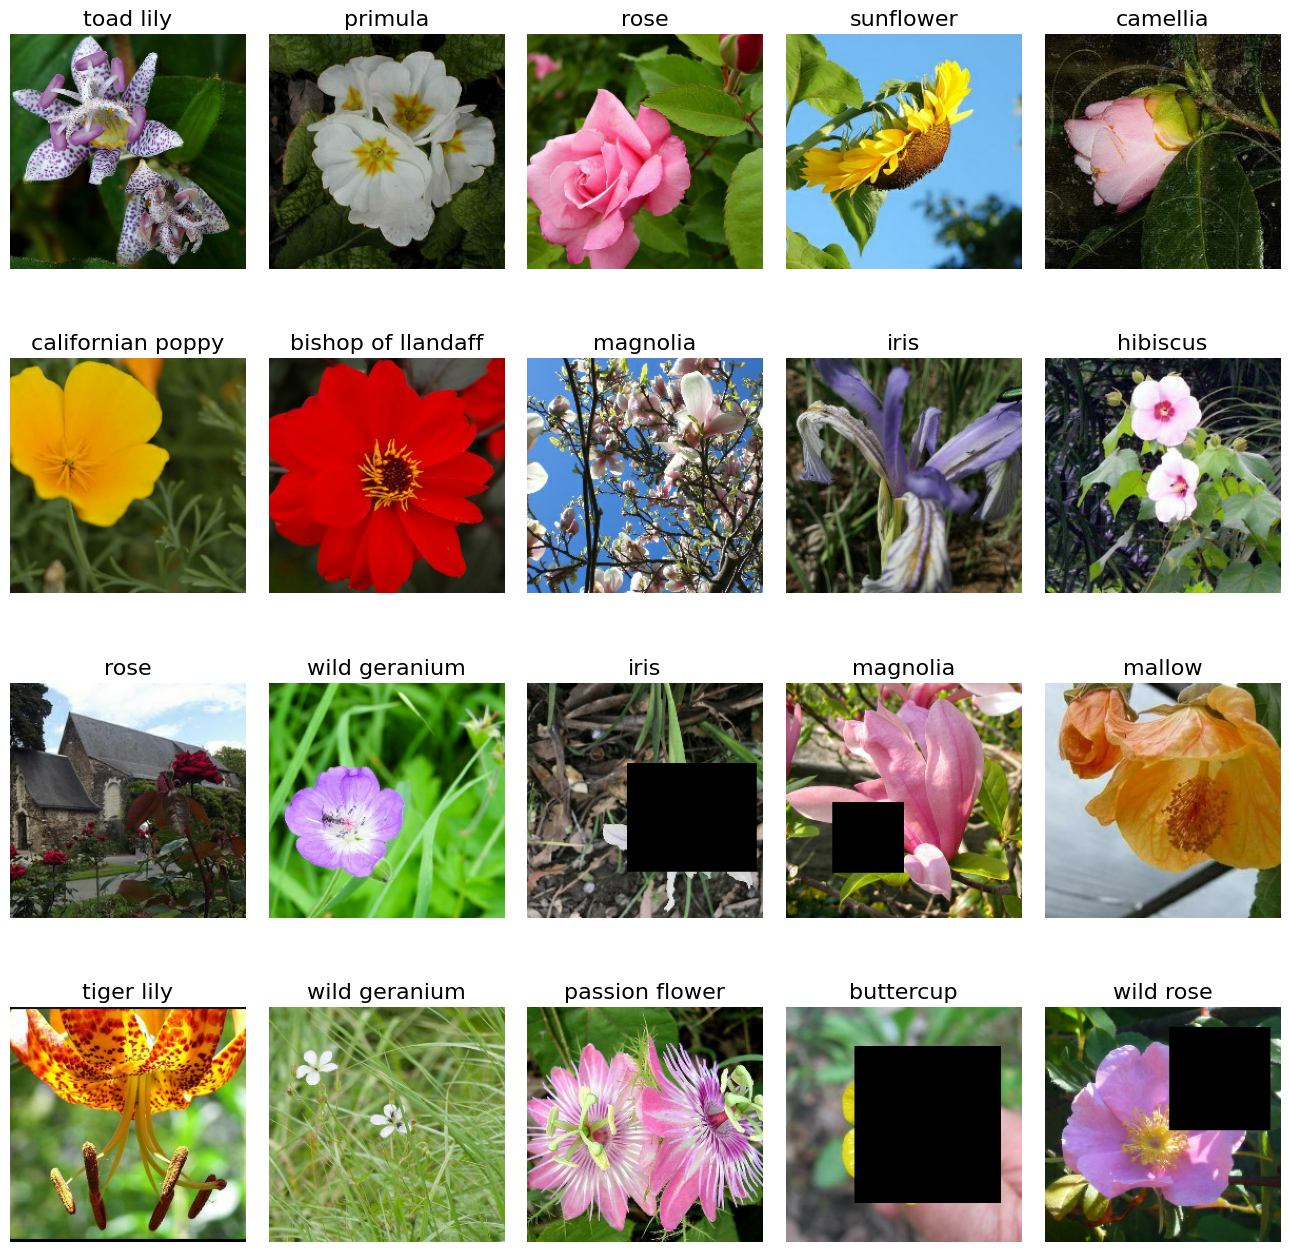

In [25]:
np.set_printoptions(threshold = 15, linewidth = 80)

def batch_to_numpy_images_and_labels(data):
    images, labels = data
    numpy_images = images.numpy()
    numpy_labels = labels.numpy()
    if numpy_labels.dtype == object:
        numpy_labels = [None for _ in enumerate(numpy_images)]
        
    return numpy_images, numpy_labels

def title_from_label_and_target(label, correct_label):
    if label is None:
        return CLASSES[correct_label], True
    correct = (label == correct_label)
    return "{} [{}{}{}]".format(CLASSES[label], 'OK' if correct else 'NO', u"\u2192" if not correct else '',
                                CLASSES[correct_label] if not correct else ''), correct

    
def display_one_flower(image, title, subplot, red=False):
    plt.subplot(*subplot)
    plt.axis('off')
    plt.imshow(image)
    plt.title(title, fontsize=16, color='red' if red else 'black')
    return (subplot[0], subplot[1], subplot[2]+1)

def display_batch_of_images(data, predictions=None):
    images, labels = batch_to_numpy_images_and_labels(data)
    if labels is None:
        labels = [None for _ in enumerate(images)]
        
    if predictions is None:
        predictions = [None for _ in enumerate(images)]
        
    batch_size = len(images)
    rows = int(np.sqrt(batch_size))
    cols = batch_size//rows
        
    FIGSIZE = 13.0
    SPACING = 0.1
    subplot = (rows, cols, 1)
    if batch_size == 1:
        plt.figure(figsize=(FIGSIZE, FIGSIZE))
        display_one_flower(images[0], title_from_label_and_target(predictions[0], labels[0]), subplot)
    else:
        plt.figure(figsize=(FIGSIZE, FIGSIZE))
        for i in range(batch_size):
            image = images[i]
            label = labels[i]
            prediction = predictions[i]
                
            title, correct = title_from_label_and_target(prediction, label)
            subplot = display_one_flower(image, title, subplot)
            
    plt.tight_layout()
    plt.subplots_adjust(wspace=SPACING, hspace=SPACING)
    plt.show()

train_data = get_train_dataset()
val_data = get_val_dataset()
display_batch_of_images(next(iter(train_data.unbatch().batch(20))))

In [26]:
def count_data_items(filenames):
    # the number of data items is written in the name of the .tfrec files, i.e. flowers00-230.tfrec = 230 data items
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in filenames]
    return np.sum(n)

numtrain = count_data_items(tf.io.gfile.glob(f'./data/tfrecords-jpeg-{size}x{size}/train/*.tfrec'))
numval = count_data_items(tf.io.gfile.glob(f'./data/tfrecords-jpeg-{size}x{size}/val/*.tfrec'))
print('Number of training images: ', numtrain)
print('Number of validation images: ', numval)

Number of training images:  12753
Number of validation images:  3712


In [27]:
# print len data with tf
def define_model():
    inputs = Input(shape=(size, size, 3))
    vgg = tf.keras.applications.VGG16(include_top=False, weights='imagenet', input_tensor=inputs)
    # vgg.trainable = False
    x = Flatten()(vgg.layers[-1].output)
    x = Dense(512, activation='relu')(x)
    # x = Dropout(0.5)(x)
    x = Dense(256, activation='relu')(x)
    # x = Dense(128, activation='relu')(x)
    outputs = Dense(104, activation='softmax')(x)
    
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

def define_model_intercep_resnet():
    inputs = Input(shape=(size, size, 3))
    resnet = tf.keras.applications.ResNet50(include_top=False, weights='imagenet', input_tensor=inputs)
    resnet.trainable = False
    # x = Flatten()(resnet.layers[-1].output)
    x = Flatten()(resnet.output)
    x = Dense(512, activation='relu')(x)
    # x = Dropout(0.5)(x)
    x = Dense(256, activation='relu')(x)
    # x = Dense(128, activation='relu')(x)
    outputs = Dense(104, activation='softmax')(x)
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

model = define_model()
model.summary()
    

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [28]:
model.fit(train_data, epochs=30, validation_data=val_data, steps_per_epoch=numtrain//64, validation_steps=numval//64)

Epoch 1/30
199/199 [==============================] - 82s 359ms/step - loss: 3.6880 - accuracy: 0.1941 - val_loss: 2.8511 - val_accuracy: 0.3529
Epoch 2/30
199/199 [==============================] - 72s 362ms/step - loss: 2.3569 - accuracy: 0.4375 - val_loss: 1.8129 - val_accuracy: 0.5585
Epoch 3/30
199/199 [==============================] - 71s 355ms/step - loss: 1.6000 - accuracy: 0.5968 - val_loss: 1.3713 - val_accuracy: 0.6444
Epoch 4/30
 43/199 [=====>........................] - ETA: 51s - loss: 1.3267 - accuracy: 0.6595